In [1]:
# load image from train folder

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
from PIL import Image
import cv2
from tqdm import tqdm

# load file from train folder
def load_file(path):
    file_list = []
    for file in os.listdir(path):
        file_list.append(file)
    return file_list

train_data = load_file('train')

# remove npy file format from train_data
train_image = [x for x in train_data if x.endswith(".npy") == False]

# sort train_image
train_image.sort()

print(len(train_image))

train_label = [x for x in train_data if x.endswith(".npy") == True]
train_label.sort()

print(len(train_label))

4135
4135


In [2]:
# pytorch image generator
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.RandomAffine(30, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=30),
                                        transforms.RandomHorizontalFlip(p=0.3),
                                        transforms.RandomCrop(256, pad_if_needed=True),
                                        transforms.Grayscale(num_output_channels=1), # turn image to 1 channel
                                        # turn image to 1 channel
                                        transforms.Normalize([0.5], [0.5]), # normalize image to [-1, 1]
                                        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                                        ])

# create custom dataset
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.file_list = []
        for file in os.listdir(self.path):
            # remove npy file format from train_data
            if file.endswith(".npy") == False:
                self.file_list.append(file)
        self.file_list.sort()
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image = Image.open(self.path + self.file_list[idx])
        image = self.transform(image)
        return image
    
class Ground_Truth(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.file_list = []
        self.image_list = []
        for file in os.listdir(self.path):
            # remove npy file format from train_data
            if file.endswith(".npy") == True:
                self.file_list.append(file)
            if file.endswith(".npy") == False:
                self.image_list.append(file)
        self.file_list.sort()
        self.image_list.sort()
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        label = np.load(self.path + self.file_list[idx])
        # get image size
        image = Image.open(self.path + self.image_list[idx])
        width, height = image.size
        label_array = np.zeros((1, height, width))
        #print(label_array.shape)
        for i in label:
            # label dot 1 aand also check if the label is out of image size
            if i[0] < width and i[1] < height:
                label_array[0][int(i[1])][int(i[0])] = 1
            # add gaussian blur
        # numpy array to image and 1 channel
        array_image = Image.fromarray(label_array[0])
        array_image = self.transform(array_image)
        # print("People: ", np.sum(label_array))
        return array_image
    
# create custom dataset from train_image list
custom_dataset = CustomDataset('train/', transform=train_transform)

# create ground truth dataset from train_label list
ground_truth = Ground_Truth('train/', transform=train_transform)

In [3]:
# using custom_dataset and ground_truth to train CSRNet

# create dataloader
train_loader = DataLoader(custom_dataset, batch_size=64, shuffle=False)
label_loader = DataLoader(ground_truth, batch_size=64, shuffle=False)

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# torchvision import
import torchvision

class Decoder(nn.Module):
  def __init__(self, in_channels, middle_channels, out_channels):
    super(Decoder, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv_relu = nn.Sequential(
        nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
        )
  def forward(self, x1, x2):
    x1 = self.up(x1)
    x1 = torch.cat((x1, x2), dim=1)
    x1 = self.conv_relu(x1)
    return x1

class Unet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(True)
        self.base_layers = list(self.base_model.children())
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            self.base_layers[1],
            self.base_layers[2])
        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]
        self.decode4 = Decoder(512, 256+256, 256)
        self.decode3 = Decoder(256, 256+128, 256)
        self.decode2 = Decoder(256, 128+64, 128)
        self.decode1 = Decoder(128, 64+64, 64)
        self.decode0 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
            )
        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        e1 = self.layer1(input) # 64,128,128
        e2 = self.layer2(e1) # 64,64,64
        e3 = self.layer3(e2) # 128,32,32
        e4 = self.layer4(e3) # 256,16,16
        f = self.layer5(e4) # 512,8,8
        d4 = self.decode4(f, e4) # 256,16,16
        d3 = self.decode3(d4, e3) # 256,32,32
        d2 = self.decode2(d3, e2) # 128,64,64
        d1 = self.decode1(d2, e1) # 64,128,128
        d0 = self.decode0(d1) # 64,256,256
        out = self.conv_last(d0) # 1,256,256
        return out

In [5]:
# model to summary
from torchsummary import summary

# define model
model = Unet(n_class=1).to(device)

# summary model
summary(model, input_size=(1, 256, 256))


/home/mllab/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/mllab/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      513,000
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1

In [6]:
image = train_loader.dataset[0]

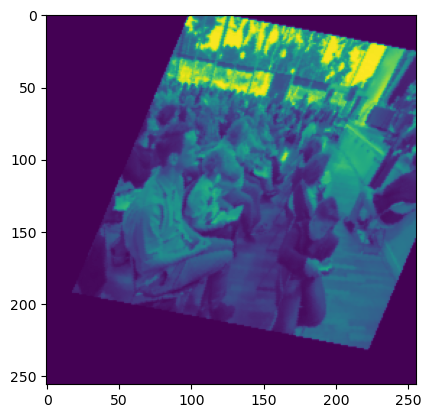

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [8]:
image.shape

torch.Size([1, 256, 256])

In [9]:
# feed image to model

output = model(image.unsqueeze(0).to(device))

print(output.squeeze(0).shape)

torch.Size([1, 256, 256])


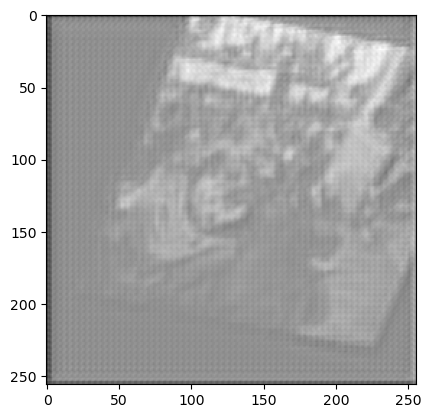

In [10]:
# show output image

plt.imshow(output.squeeze(0).permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')

torch.Size([1, 256, 256])


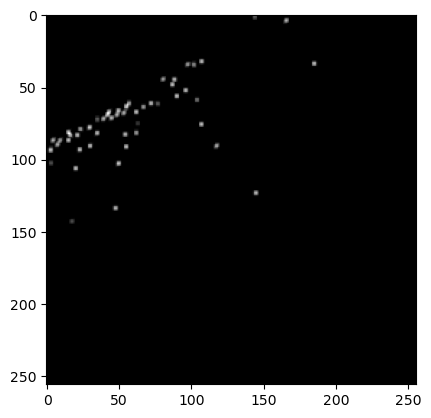

In [11]:
# show ground truth image

print(label_loader.dataset[0].shape)
plt.imshow(label_loader.dataset[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')

In [12]:
# bayesian loss for crowd counting with U-Net

# define loss function
class BayesianLoss(nn.Module):
    def __init__(self):
        super(BayesianLoss, self).__init__()
        self.loss = nn.MSELoss(reduction='mean')
    
    def forward(self, pred, gt, var):
        # calculate loss
        loss = torch.sum((pred - gt)**2 / var + torch.log(var))
        return loss
    
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# define loss function
criterion = BayesianLoss()

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, min_lr=1e-5, verbose=True)

# define epoch
epoch = 100

# define list to store loss
train_loss = []

In [13]:
# train model
for i in range(epoch):
    # set model to train mode
    model.train()
    # define loss
    loss = 0
    # iterate over train_loader
    for image, label in zip(train_loader, label_loader):
        # feed image to model
        output = model(image.to(device))
        # calculate loss
        loss = criterion(output.squeeze(0), label.to(device), torch.ones_like(output.squeeze(0)))
        optimizer.zero_grad()
        # backward loss
        loss.backward()
        # update parameters
        optimizer.step()
    # append loss to train_loss
    train_loss.append(loss.item())
    # print loss
    print("Epoch: {}, Loss: {}".format(i, loss.item()))
    # zero grad